In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from pandas.plotting import register_matplotlib_converters
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv(r'C:\Users\Mohamed Fawzi\OneDrive\Área de Trabalho\Stock Price Analysis\Stock Prices Data Set.csv')

df.head()

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


## Preparing & Cleaning Data:

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497472 entries, 0 to 497471
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  497472 non-null  object 
 1   date    497472 non-null  object 
 2   open    497461 non-null  float64
 3   high    497464 non-null  float64
 4   low     497464 non-null  float64
 5   close   497472 non-null  float64
 6   volume  497472 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 26.6+ MB


In [35]:
# Statistics of the dataset
df.describe()

,open,high,low,close,volume
count,497461.000000,497464.000000,497464.000000,497472.000000,4.974720e+05
mean,86.352275,87.132562,85.552467,86.369082,4.253611e+06
std,101.471228,102.312062,100.570957,101.472407,8.232139e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,41.690000,42.090000,41.280000,41.703750,1.080166e+06
50%,64.970000,65.560000,64.353700,64.980000,2.084896e+06
75%,98.410000,99.230000,97.580000,98.420000,4.271928e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [36]:
#checking for null values
df.isnull().sum()

symbol     0
date       0
open      11
high       8
low        8
close      0
volume     0
dtype: int64

In [37]:
# filling null values with previous values
df.fillna(method='ffill', inplace=True)

In [38]:
# convert the 'Date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497472 entries, 0 to 497471
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   symbol  497472 non-null  object        
 1   date    497472 non-null  datetime64[ns]
 2   open    497472 non-null  float64       
 3   high    497472 non-null  float64       
 4   low     497472 non-null  float64       
 5   close   497472 non-null  float64       
 6   volume  497472 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 26.6+ MB


## Exploratory Data Analysis (EDA):

-   I will analyze the top 5 symbols with highest volume 

In [40]:
# top 5 symbols by volume
top_5_symbols = df.groupby('symbol')['volume'].sum().nlargest(5).index.tolist()
top_5_symbols

['BAC', 'AAPL', 'GE', 'AMD', 'F']

In [41]:
# mapping symbols to their respective full names
symbol_name = {
    'BAC': 'Bank of America',
    'AAPL': 'Apple Inc.',
    'GE': 'General Electric',
    'AMD': 'Advanced Micro Devices',
    'F': 'Ford Motor Company',
    
}

df['company name'] = df['symbol'].map(symbol_name)


In [42]:
# the top 5 symbols by volume
top_5_companies = df.groupby('company name')['volume'].sum().nlargest(5).reset_index()
top_5_companies

,company name,volume
0,Bank of America,89988444028
1,Apple Inc.,45485758169
2,General Electric,41734050117
3,Advanced Micro Devices,33522535638
4,Ford Motor Company,33144701045


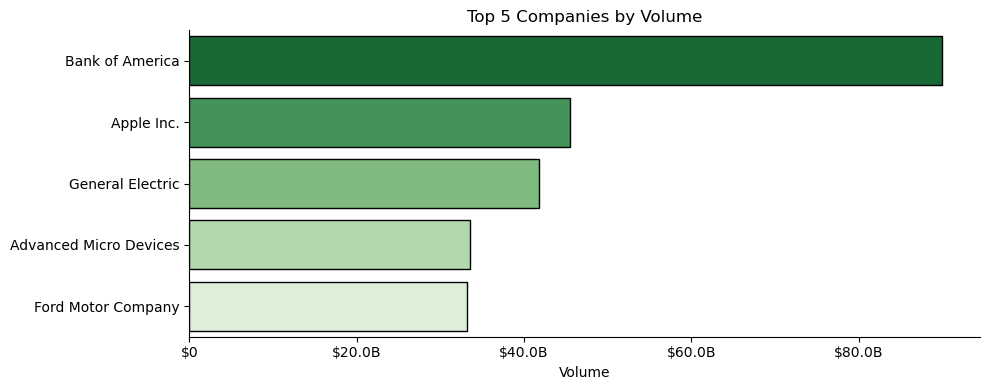

In [43]:
plt.figure(figsize=(10, 4))
sns.barplot(
    data=top_5_companies,
    y='company name',
    x='volume',
    palette='Greens_r',
    edgecolor='black',    
)

def currency(x, pos):
    if x >= 1e9:
        return f'${x*1e-9:.1f}B'
    elif x >= 1e6:
        return f'${x*1e-6:.1f}M'
    elif x >= 1e3:
        return f'${x*1e-3:.1f}K'
    else:
        return f'${x:.0f}'

plt.gca().xaxis.set_major_formatter(FuncFormatter(currency))

plt.title('Top 5 Companies by Volume')
plt.xlabel('Volume')
plt.ylabel('')



sns.despine()
plt.tight_layout()
plt.show()

-   **Key Insight**

    - **Bank of America** leads significantly in trading volume, indicating high investor interest or market activity.
    - **Apple Inc.** and **General Electric** follow as the next most traded stocks, but their volumes are notably lower than Bank of America's.
    - **Advanced Micro Devices** and **Ford Motor Company** complete the top 5, showing moderate trading interest.
    - The sharp drop after Bank of America suggests a **concentration of trading activity** in fewer stocks, potentially due to sector-specific news or broader market trends.

    ____________


-   Now, let's visualizes the closing stock prices over time for the top 5 performing companies. I will filter the dataset to include only those companies.

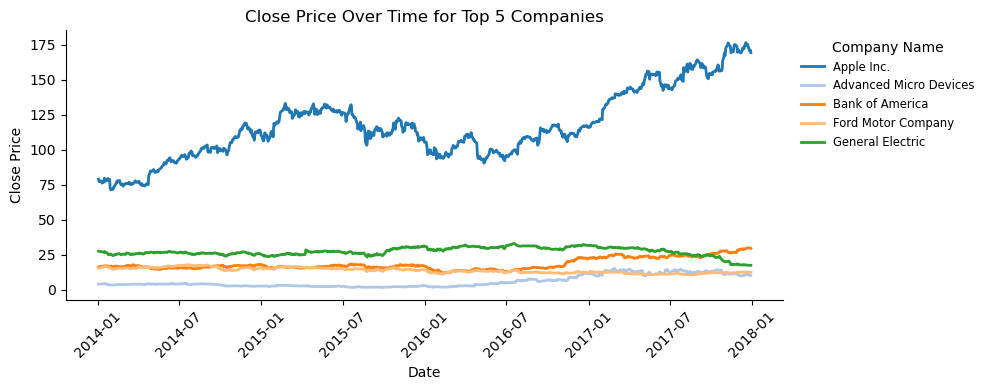

In [44]:
top_5_companies_list = top_5_companies['company name'].tolist()
df_top_5_companies = df[df['company name'].isin(top_5_companies_list)]

plt.figure(figsize=(10, 4))
sns.lineplot(
    data=df_top_5_companies,
    x='date',
    y='close',
    hue='company name',
    palette='tab20',
    linewidth=2,
)

plt.title('Close Price Over Time for Top 5 Companies')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title='Symbol', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.legend(title='Company Name', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False, fontsize='small')

sns.despine()
plt.tight_layout()
plt.show()

-   **Key Insight**

    - **Apple Inc.** shows a strong upward trend from 2014 to 2018, significantly outperforming all other companies in terms of stock price growth.
    - **General Electric** remained relatively stable until a notable decline after 2017, suggesting potential structural or financial concerns.
    - **Bank of America** exhibited a gradual recovery, especially post-2016, reflecting improving investor sentiment or financial performance.
    - **Advanced Micro Devices** and **Ford Motor Company** maintained lower price ranges throughout the period, with AMD showing some upward momentum in the latter part of the timeline.
    - Overall, the chart highlights **Apple’s dominance in stock performance** compared to the other top-volume companies.
________

### **Moving Average(MA):**

-   A Moving Average (MA) is a widely used indicator in stock market analysis that helps smooth out price data over a specified time period. It calculates the average closing price of a stock over a set number of days (known as the "window"), updating with each new day.

-   There are two common types:

    -   Short-Term Moving Average (e.g., 50-day): Reacts faster to recent price changes and shows short-term trends.
    -   Long-Term Moving Average (e.g., 200-day): Slower to react, but shows the overall, long-term direction of the stock price.

-   Let's prepare the data for calculating moving averages by setting the 'date' column as the index and identifying unique company names. It defines short-term (50-day) and long-term (200-day) window sizes, which will be used to compute moving averages — key indicators in identifying trends in stock prices. 

In [ ]:
df_companies = df[df['symbol'].isin(top_5_symbols)]
df_companies = df_companies.sort_values(by='date')

short_window = 50
long_window = 200

df_companies.copy().set_index('date', inplace=True)
unique_compnies = df_companies['company name'].unique()

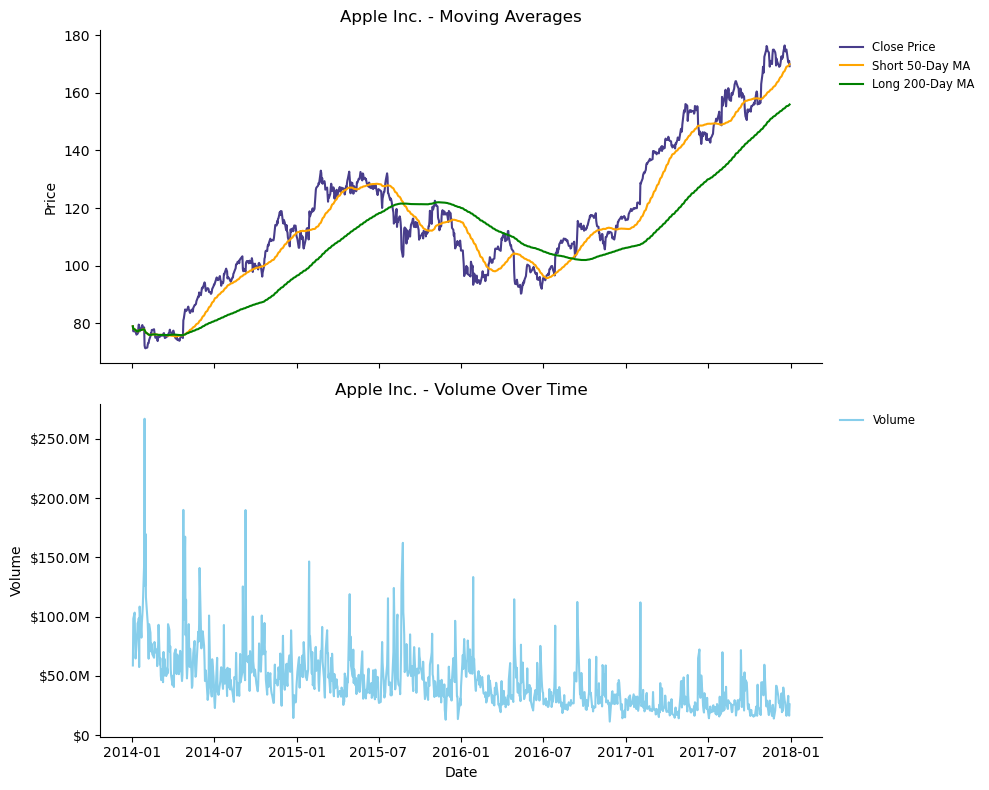

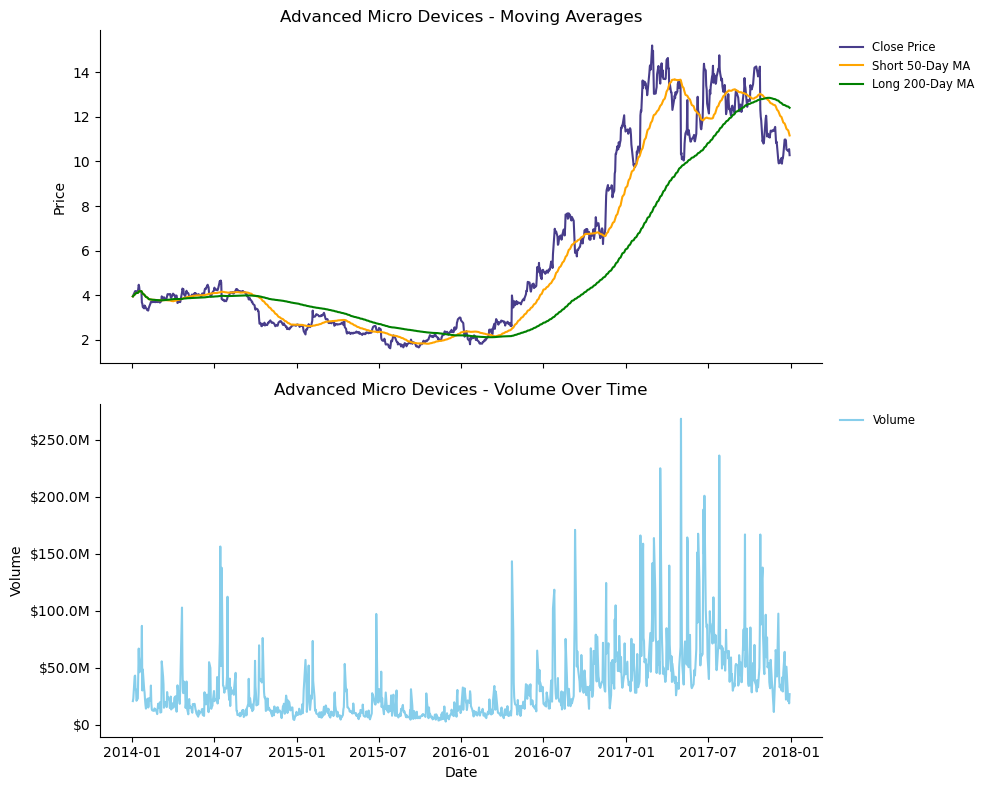

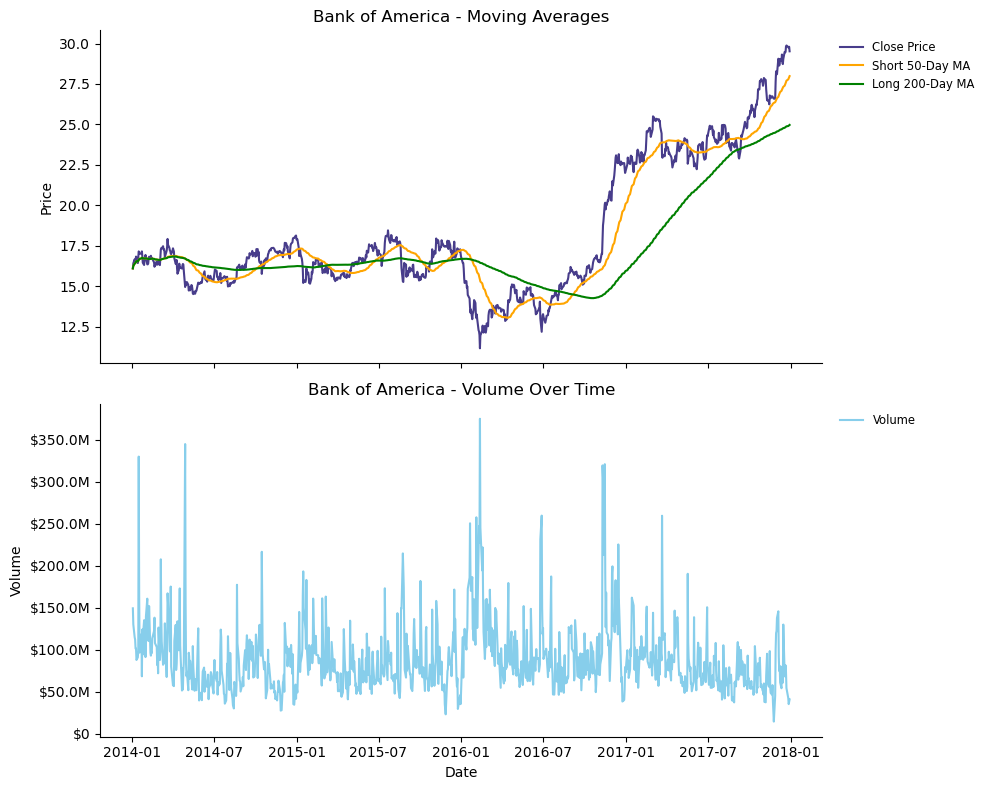

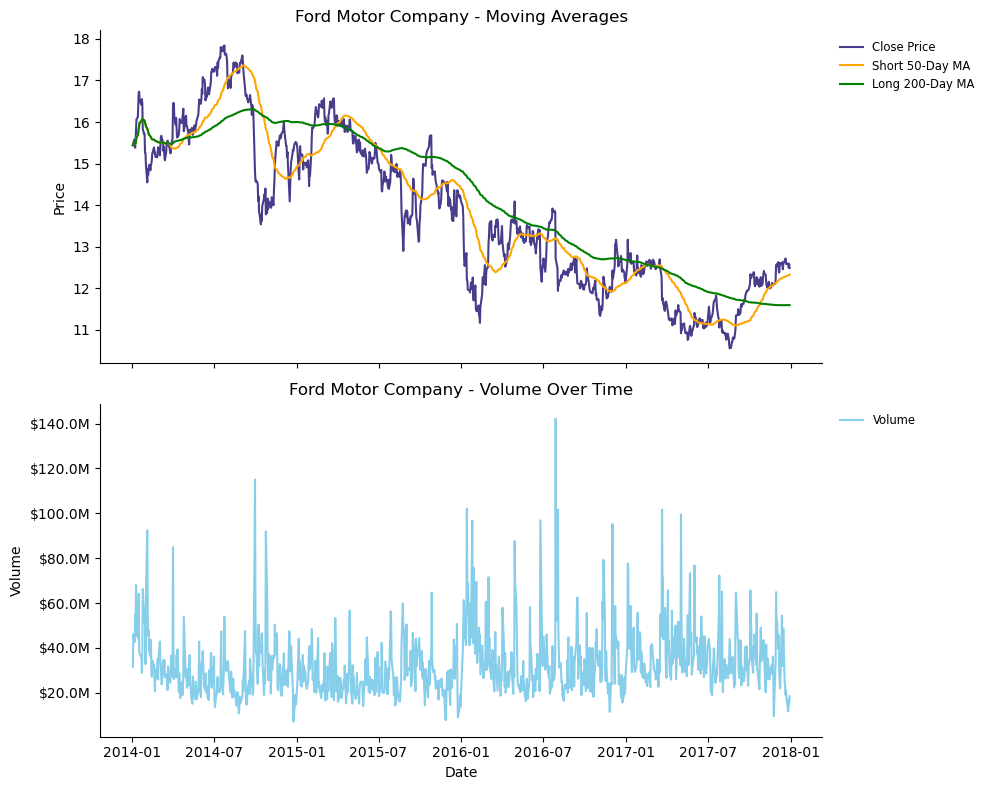

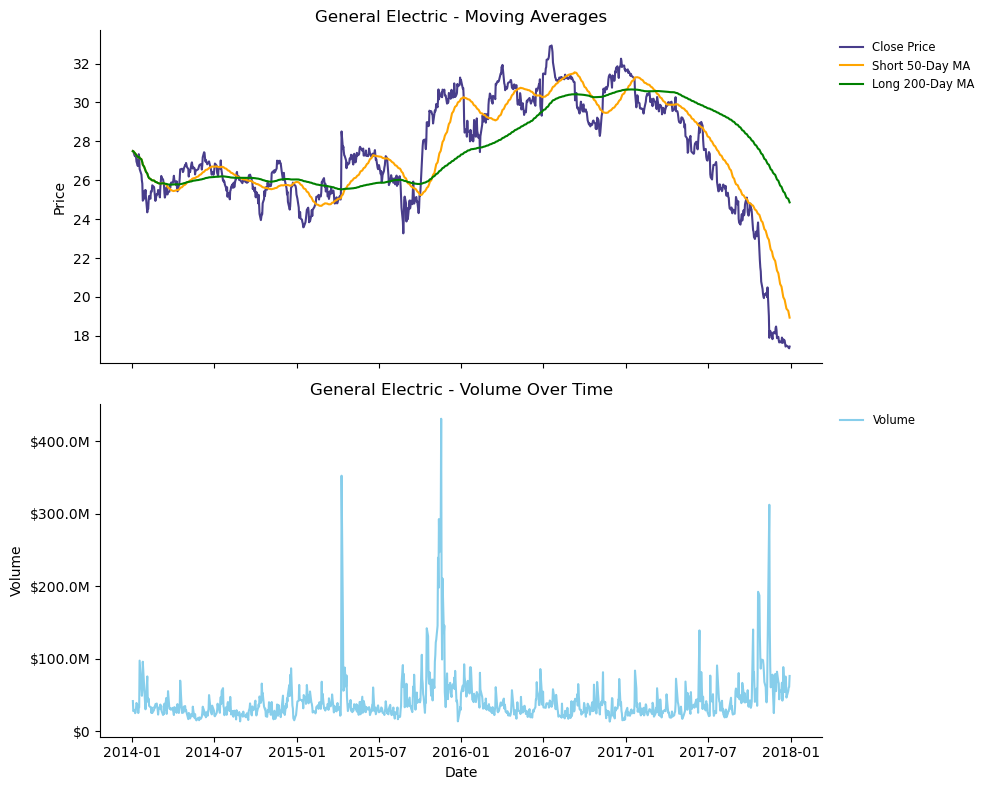

In [ ]:

for company in unique_compnies:
    company_data = df_companies[df_companies['company name'] == company].copy()
    company_data['short_mavg'] = company_data['close'].rolling(window=short_window, min_periods=1).mean()
    company_data['long_mavg'] = company_data['close'].rolling(window=long_window, min_periods=1).mean()
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)  # 2 rows, 1 col
    
    # First subplot: price and moving averages
    sns.lineplot(data=company_data, x='date', y='close', label='Close Price', color='darkslateblue', ax=axs[0])
    sns.lineplot(data=company_data, x='date', y='short_mavg', label=f'Short {short_window}-Day MA', color='orange', ax=axs[0])
    sns.lineplot(data=company_data, x='date', y='long_mavg', label=f'Long {long_window}-Day MA', color='green', ax=axs[0])
    axs[0].set_title(f'{company} - Moving Averages')
    axs[0].set_ylabel('Price')
    axs[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='small', frameon=False)
    sns.despine(ax=axs[0])
    
    # Second subplot: volume
    sns.lineplot(data=company_data, x='date', y='volume', label='Volume', color='skyblue', ax=axs[1])
    axs[1].yaxis.set_major_formatter(FuncFormatter(currency))  # your currency formatting function
    axs[1].set_title(f'{company} - Volume Over Time')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Volume')
    axs[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='small', frameon=False)
    sns.despine(ax=axs[1])
    
    plt.tight_layout()
    plt.show()
   

-   **Key Insights**

    -   **Apple Inc. - Moving Averages**

        - The **short-term 50-day MA** (orange line) closely tracks price movements and frequently crosses the **long-term 200-day MA** (green line), generating trading signals.
        - Notable **Golden Crosses** (where the 50-day MA crosses above the 200-day MA) occur in mid-2014 and early 2017, both followed by strong upward trends.
        - A **Death Cross** around mid-2015–2016 indicated a temporary downtrend before recovery.
        - The chart highlights how moving averages can effectively signal **trend reversals** and **confirm long-term momentum** in stock prices.

    -   **Apple Inc. - Volume Over Time**
        - Trading **volume shows a clear declining trend** from 2014 to 2018, suggesting reduced short-term trading activity over time.
        - Despite a few **sporadic volume spikes**, the overall volume became more stable and lower, possibly reflecting a shift toward longer-term investors or less speculative trading.
        - The **early high-volume periods** might be linked to product launches, earnings reports, or broader market events.
        - Lower volume in later years, despite rising prices, may indicate **stronger investor confidence and reduced volatility**.


    -   **AMD - Moving Averages**
        - From 2014 to early 2016, AMD traded sideways with low volatility, as both moving averages remained relatively flat and close.
        - A strong **uptrend began in mid-2016**, marked by a **Golden Cross**, where the 50-day MA crossed above the 200-day MA — a classic bullish signal.
        - AMD's price surged dramatically through 2017, with both MAs trending upward, reinforcing sustained bullish momentum.
        - Toward late 2017, a **Death Cross** began to form, where the 50-day MA dipped below the 200-day MA, indicating possible trend reversal or correction.
        - The chart effectively captures AMD’s **transition from stagnation to high growth**, with moving averages offering valuable confirmation signals.

    -   **AMD - Volume Over Time**
        - **Volume remained relatively low and stable** from 2014 to early 2016, reflecting limited investor interest or market movement.
        - A **clear surge in volume** begins in mid-2016 and intensifies through 2017, aligning with AMD’s strong price rally during the same period.
        - Multiple **volume spikes** in 2017 suggest periods of heightened investor activity, likely due to earnings reports, product releases, or broader semiconductor sector momentum.
        - The increasing volume supports the price trend shown in the MA chart, indicating strong **market participation during AMD's growth phase**.



    -   **Bank of America - Moving Averages**
        - From 2014 to mid-2016, Bank of America’s price experienced **sideways movement** with modest volatility, and the moving averages frequently converged, indicating market indecision.
        - A **significant downtrend** in early 2016 is marked by the 50-day MA crossing below the 200-day MA (a bearish signal).
        - A **strong uptrend began mid-2016**, with a notable **Golden Cross** where the 50-day MA crossed above the 200-day MA, supported by a sharp price breakout.
        - From late 2016 through 2017, the gap between the short and long MAs widened, confirming **sustained bullish momentum**.
        - This moving average analysis highlights the shift from consolidation to breakout, helping to time trend entries effectively.

    -   **Bank of America - Volume Over Time**
        - Trading volume fluctuates, with **peaks at various points**, suggesting heightened investor activity.
        - The highest spikes occur **in mid-2016 and early 2017**, possibly due to major financial events or market shifts.
        - Volume activity does not show a clear trend but reflects **periodic surges in interest**.



    -   **Ford Motor Company - Moving Averages**
        - The stock price shows **fluctuations** between **$11 and $18** from 2014 to 2018.
        - The **50-day moving average (orange line)** follows the stock price closely, reflecting short-term trends.
        - The **200-day moving average (green line)** smooths out volatility, highlighting long-term movements.
        - When the stock price crosses the moving averages, it can signal **potential buying or selling opportunities**.

    -   **Ford Motor Company - Volume Over Time**
        - Trading volume ranges from **$0M to $140M**, with **significant fluctuations** over time.
        - Peak trading activity appears at **various points**, possibly indicating major news or investor sentiment shifts.
        - The volume trends don’t show a clear uptrend or downtrend, suggesting **variable market interest** in Ford.
    


    -   General Electric – Moving Averages & Volume Insight

        - From 2014 to 2016, GE's price remained relatively stable with **short fluctuations** around the 50-day and 200-day moving averages.
        - A **clear bullish phase** emerged mid-2016, when the 50-day MA crossed above the 200-day MA and the stock climbed toward $32.
        - However, in **early 2017**, the price reversed sharply, and the 50-day MA **dropped below** the 200-day, confirming a **bearish trend**.
        - The stock experienced a **steep decline throughout 2017**, closing near $18 by the end of the year.
        - Volume spikes—especially during sharp declines—suggest **panic selling or institutional unloading**, supporting the downtrend signal.
        - Overall, the trend shows a **strong bearish reversal** after a short-lived rally, confirmed by both moving averages and volume surges.


_____________

### **Daily Return:**
    
-   Daily Return is the percentage change in a stock’s price from one day to the next.
It tells you how much the stock gained or lost in value each day, expressed as a percentage.

-   Now, I will calculate the daily percentage return for each company’s stock by computing the percentage change between consecutive closing prices. This helps in analyzing the stock's volatility and performance over time.

In [ ]:
df_companies['daily_return'] = df_companies.groupby('company name')['close'].pct_change()

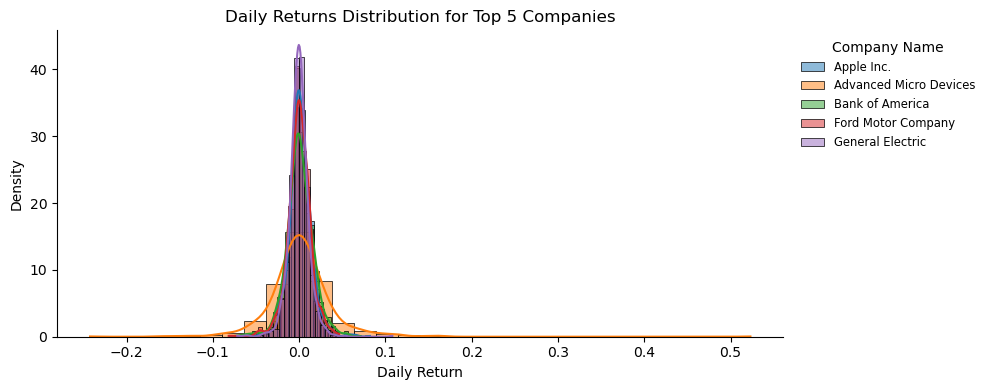

In [ ]:
plt.figure(figsize=(10, 4))
for company in unique_compnies:
    company_data = df_companies[df_companies['company name'] == company]
    sns.histplot(
        data=company_data,
        x='daily_return',
        label=company,
        kde=True,
        stat='density',
        bins=30,
        edgecolor='black',
        linewidth=0.5,
        palette='Set1',
        fill=True
    )
plt.title('Daily Returns Distribution for Top 5 Companies')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend(title='Company Name', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False, fontsize='small')
sns.despine()
plt.tight_layout()
plt.show()

- **Key Insights**

  - Most Returns Are Clustered Around Zero  
      - The peak of each distribution is centered around **0% daily return**, indicating that most days, the stock prices of these companies do not experience significant gains or losses.  
      - This suggests that small price fluctuations are common, while extreme movements are rare.

  - Symmetry (or Lack Thereof) in Distributions  
    - Some stocks show **symmetrical distributions** (e.g., Apple Inc.), suggesting balanced volatility.  
    - Others show **skewness**:  
      - **Right-skewed**: More frequent small losses but occasional large gains.  
      - **Left-skewed**: More frequent small gains but occasional large losses.  
    - Example: **Advanced Micro Devices** shows a slight right skew.

  - Volatility Differences Between Companies  
    - The **width** of the distribution reflects **volatility**:  
      - **Wider distributions** = higher volatility (e.g., General Electric, Advanced Micro Devices)  
      - **Narrower distributions** = lower volatility (e.g., Bank of America)

  - Outliers and Extreme Returns  
    - **Longer tails** indicate a higher probability of extreme returns:  
      - **General Electric** has long tails → more risk/reward potential  
      - **Ford Motor Company** has shorter tails → fewer extreme events


  - Risk Assessment  
    - **High volatility stocks**: Riskier investments with potential for larger gains/losses.  
    - **Low volatility stocks**: Safer investments with steadier returns.

---


### **Correlation:**
-   A high correlation (close to 1) means two stocks tend to move in the same direction, while a low or negative value indicates they move independently or in opposite directions. This helps in understanding diversification opportunities and portfolio risk.

-   Now, let's visualizes the **correlation matrix** of daily returns among the top 5 companies.

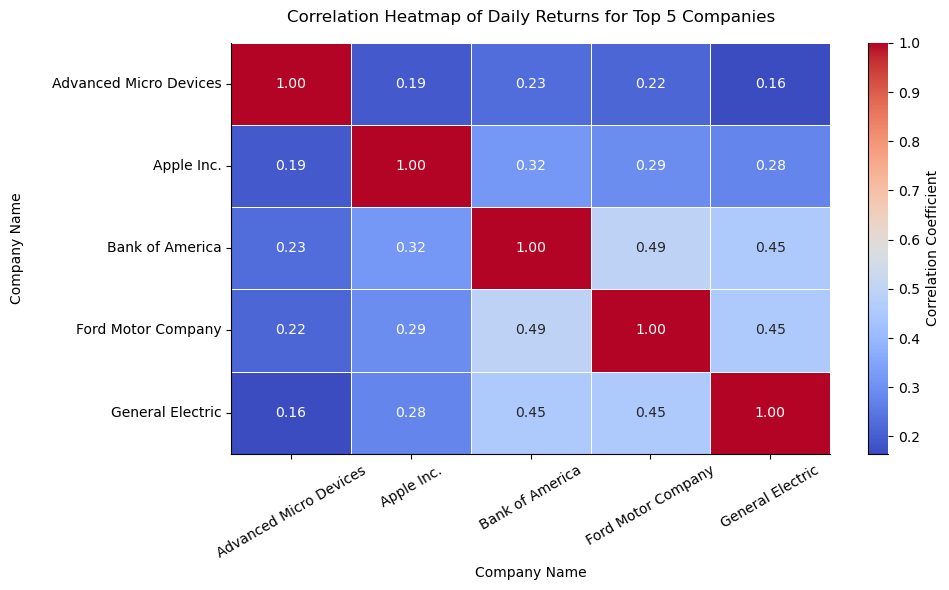

In [ ]:
daily_returns = df_companies.pivot_table(
    index='date',
    columns='company name',
    values='daily_return'
)
daily_returns = daily_returns.dropna()

plt.figure(figsize=(10, 6))
sns.heatmap(
    daily_returns.corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Heatmap of Daily Returns for Top 5 Companies', pad=15)
plt.xlabel('Company Name')
plt.ylabel('Company Name', labelpad=20)
plt.xticks(rotation=30)
sns.despine()
plt.tight_layout()
plt.show()

-   **Key Insights**

    -   Self-Correlation (Diagonal Values)
        - Each company has a perfect correlation with itself (**1.00**), as expected.
        - This confirms that each stock’s daily return is perfectly aligned with itself.

    -   Positive Correlations
        - **Strongest Pair: Bank of America ↔ Ford Motor Company (0.49)**
            - These two stocks tend to move together, suggesting similar exposure to market or sector factors.
        - **General Electric ↔ Ford Motor Company (0.45)**
            - Also shows a strong positive relationship.
        - **Apple Inc. ↔ Bank of America (0.32)**
            - Indicates moderate co-movement between tech and finance sectors.

    -   Weak or Low Correlations
        - **Advanced Micro Devices** shows low correlations with all other companies:
            - **Apple Inc. (0.19)**
            - **Bank of America (0.23)**
            - **Ford Motor Company (0.22)**
            - **General Electric (0.16)**
        - **Apple Inc. ↔ General Electric (0.28)**
            - Suggests limited shared movement between these two.

    -   Diversification Opportunities
        - **Low-correlation assets** like **Advanced Micro Devices** are valuable for diversifying a portfolio.
        - **Highly correlated pairs** (e.g., Bank of America and Ford Motor Company) may not significantly reduce risk if held together.

    -   Market Behavior Insights
        - The heatmap reveals mixed behavior — some stocks move together due to common influences (industry, macroeconomic factors), while others behave independently.
        - Understanding these patterns helps identify which stocks respond similarly to market events.

---


### **Optimization:**

-   I will calculate the **annualized expected returns** and **volatility (risk)** for each stock based on historical daily returns.

    - `**Expected_Returns**`: The average daily return is multiplied by 252 to annualize it (assuming 252 trading days in a year).
    - `**Volatility**`: The standard deviation of daily returns is multiplied by the square root of 252 to annualize it.
    - These values are then combined into a DataFrame showing each company's expected return and associated risk.

In [ ]:
expected_returns = daily_returns.mean() * 252  # annualize the returns
volatility = daily_returns.std() * np.sqrt(252)  # annualize the volatility

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats.round(4)

,Expected Return,Volatility
company name,,
Advanced Micro Devices,0.4245,0.6207
Apple Inc.,0.2166,0.2271
Bank of America,0.1846,0.2558
Ford Motor Company,-0.0288,0.2201
General Electric,-0.0963,0.1881




-   **Insights:**

    - **Advanced Micro Devices** offers the **highest expected return (42.45%)**, but it also comes with the **highest volatility (62.07%)**, making it the riskiest investment.
    - **Apple Inc.** and **Bank of America** show **positive returns** with **moderate volatility**, indicating a more balanced risk-return profile.
    - **Ford Motor Company** and **General Electric** have **negative expected returns**, suggesting declining trends in their stock prices over the period analyzed.
    - All companies exhibit varying levels of risk, which should be considered alongside return expectations when constructing an optimized portfolio.


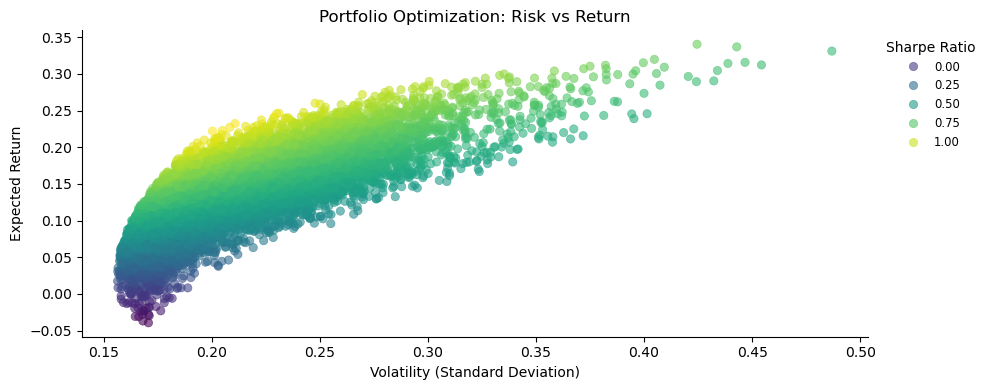

In [ ]:
# function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# arrays to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_compnies))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 4))
sns.scatterplot(
    x=results[1,:],
    y=results[0,:],
    hue=results[2,:],
    palette='viridis',
    alpha=0.6,
    edgecolor=None
)

plt.title('Portfolio Optimization: Risk vs Return')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend(title='Sharpe Ratio', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False, fontsize='small')
#plt.grid()
sns.despine()
plt.tight_layout()
plt.show()


**Key Insights:**

-   Risk-Return Tradeoff  
    - The plot shows a clear **tradeoff between risk and return**:
        - **Left side**: Lower volatility, lower expected returns  
        - **Right side**: Higher volatility, higher expected returns  
    - This aligns with the principle that **higher returns typically come with higher risks**.

-   Efficient Frontier  
    - The **upper boundary** of the scatter plot represents the **efficient frontier** — the set of portfolios that offer the **highest expected return for a given level of risk**.
    - These portfolios are **optimal**, maximizing returns without unnecessary risk.

-   Sharpe Ratio as a Measure of Efficiency  
    - The **color gradient** indicates the **Sharpe Ratio**, which measures **return per unit of risk**:
        - **Darker colors (purple/blue)** = lower Sharpe Ratios (poor risk-adjusted performance)  
        - **Lighter colors (yellow/green)** = higher Sharpe Ratios (better risk-adjusted performance)  
    - The **green-yellow region** along the efficient frontier contains the most desirable portfolios.

-   High-Risk, High-Return Portfolios  
    - On the **top-right corner**:
        - Portfolios with **high volatility (>0.45)** and **high returns (>0.30)**  
        - Suitable for **aggressive investors** who can tolerate high risk for potential reward

-   Low-Risk, Low-Return Portfolios  
    - On the **bottom-left corner**:
        - Portfolios with **low volatility (<0.20)** and **low returns (<0.10)**  
        - Ideal for **risk-averse investors** who prioritize stability over growth

-   Optimal Portfolio Region  
    - The **region with the highest Sharpe Ratio** (lightest green/yellow) is where the **optimal portfolios** lie:
        - These balance **risk and return** effectively  
        - Investors should focus on these when constructing their portfolio

-   Outliers and Extreme Points  
    - Some portfolios appear as **outliers**:
        - **Very high-risk, very low-return portfolios** → inefficient, avoid them  
        - **Very low-risk, very high-return portfolios** → likely unrealistic or anomalous

---


-   Now, let's identify the **portfolio with the highest Sharpe Ratio** from the 10,000 simulated portfolios.

In [ ]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.2219682245380699, 0.20037189025807617, 1.107781257401814)

- **Expected Annual Return**: 22.20%  
- **Annual Volatility (Risk)**: 20.04%  
- **Sharpe Ratio**: 1.11  

This portfolio offers the **best risk-adjusted return** among all simulated portfolios. With a Sharpe Ratio of **1.11**, it delivers a strong balance between return and risk, making it a strong candidate for investment based on modern portfolio theory.

-   Let's identify the **portfolio weights** that correspond to the **maximum Sharpe Ratio** found earlier.

In [ ]:
max_sharpe_weights = np.zeros(len(unique_compnies))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_compnies))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_compnies,
    'Weight': max_sharpe_weights
})

portfolio_weights_df.round(4)

,Ticker,Weight
0,Apple Inc.,0.2996
1,Advanced Micro Devices,0.1751
2,Bank of America,0.0669
3,Ford Motor Company,0.2287
4,General Electric,0.2296


-   This table shows the **optimal allocation of funds** across the top 5 companies that yields the **highest Sharpe Ratio**, meaning the best return per unit of risk.

    - **Apple Inc.** has the highest weight (**~30%**), indicating it contributes significantly to balancing risk and return.
    - **Advanced Micro Devices** is allocated **~17.5%**, reflecting its higher return but also higher volatility.
    - **Ford Motor Company** and **General Electric** receive similar weights (**~23% each**), suggesting they contribute to diversification.
    - **Bank of America** receives the smallest weight (**~6.7%**) due to its moderate return and relatively higher volatility compared to others.

This optimal portfolio provides a data-driven strategy for investors aiming to maximize returns while managing risk effectively.

_______

## ✅ Final Insights and Recommendations

-   **Key Outcomes from the Analysis:**
    - **Optimal Portfolio Allocation**:  
    The portfolio with the **highest Sharpe Ratio (1.11)** offers a balanced mix of risk and return:  
        - **Apple Inc. (30%)**: Strong performer with moderate risk.  
        - **Advanced Micro Devices (17.5%)**: High reward but high volatility.  
        - **Ford Motor Company (22.9%)** and **General Electric (22.9%)**: Diversification anchors.  
        - **Bank of America (6.7%)**: Minimal allocation due to moderate returns and higher risk.

- **Risk-Return Tradeoff**:  
  Higher returns (e.g., AMD) come with significant volatility, while stable stocks (e.g., Bank of America) offer lower growth. Investors must align allocations with their risk tolerance.

- **Diversification Opportunities**:  
  Stocks like **Advanced Micro Devices** show low correlation with others, making them ideal for reducing portfolio risk.

- **Company Performance Highlights**:  
  - **Apple Inc.**: Dominated in growth and stability.  
  - **Advanced Micro Devices**: High-risk, high-reward profile.  
  - **General Electric** and **Ford Motor Company**: Mixed performance with declining trends.  
  - **Bank of America**: Stable but underperformed in returns.

### 🚀 Strategic Takeaways:
- Prioritize **Apple Inc.** and **AMD** for growth-focused portfolios.  
- Use **Ford** and **GE** for diversification.  
- Avoid overexposure to low Sharpe Ratio stocks (e.g., Bank of America).  
- Regularly rebalance the portfolio to adapt to market shifts.

________

**Prepared by     :   Mohamed Fawzi**

**Email : modyreturn@gmail.com**

**Github : https://github.com/modyreturn**